# Galaxies Morphology Classification Using Convolutional Neural Networks

v0.1

Import required libraries.

In [1]:
%matplotlib inline
import pandas as pd
import os, random, shutil

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

Set the base path for the Galaxy Zoo dataset, available from: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge

In [2]:
base_path = r'/tmp/galaxy-zoo'

Set the path for the CSV file with the training solutions, and the path to the training images directory.

In [3]:
training_solutions = os.path.join(base_path, 'training_solutions_rev1.csv')
training_images    = os.path.join(base_path, 'images_training_rev1')

## 1. Introduction

At this stage we are mainly interested in three major types of galaxies:

1. Elliptical galaxies (early type);
2. Lenticular galaxies (in-between);
3. Spiral galaxies (late type);

To come up with a collection of images for each one og these classes, we sub-set some images in the Galaxy Zoo dataset based on the probabilities distributions available in the CSV file. The entire dataset is comprised of 61578 images. 

To find a sub-set for each type we define a path in the decision tree to select observartions as follows:

1. Elliptical: Q1.1 > 0.8 and Q7.1 > 0.4
2. Lenticular: Q1.1 > 0.8 and Q7.2 > 0.4
3. Spiral: Q1.2 > 0.8 and Q2.1 > 0.4

## 2. Create the Dataset

Read the training probablilities CVS file to a pandas dataframe.

In [4]:
df = pd.read_csv(training_solutions)

Update column names replacing the 'Class' string with 'Q':

In [5]:
cols = df.columns
new = list(map(lambda s: s.replace('Class','Q'), cols))
df.columns = new

Inspect the shape of the dataframe to verufy that we have 61578 galaxies (rows) and 37 probabilities

In [6]:
df.shape

(61578, 38)

Inspect the first dataframe rows

In [7]:
df.head()

,GalaxyID,Q1.1,Q1.2,Q1.3,Q2.1,Q2.2,Q3.1,Q3.2,Q4.1,Q4.2,...,Q9.3,Q10.1,Q10.2,Q10.3,Q11.1,Q11.2,Q11.3,Q11.4,Q11.5,Q11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


Get a colection of IDs according to the sub-sets defined earlier:

In [8]:
ellipticals = df[(df['Q1.1']>0.8) & (df['Q7.1']>0.4)]['GalaxyID'].tolist()

In [9]:
lenticulars = df[(df['Q1.1']>0.8) & (df['Q7.2']>0.4)]['GalaxyID'].tolist()

In [10]:
spirals = df[(df['Q1.2']>0.8) & (df['Q2.1']>0.4)]['GalaxyID'].tolist()

Inspect the total number of galaxies in each class:

In [11]:
print('Total number of elliptical examples: ',  len(ellipticals))
print('Total number of lenticular examples: ',  len(lenticulars))
print('Total number of spiral examples: ',  len(spirals))

Total number of elliptical examples:  4555
Total number of lenticular examples:  3861
Total number of spiral examples:  3078


Create a function that randomly copies the images for a given class (label) to the corresponding training and validation directories, these are later used in the datasets generators:

In [12]:
def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')

Set a base directory for our data:

In [13]:
my_data = os.path.join(base_path, 'data')

Run the previous function for each class of interest: elliptical, lenticular and spiral. Using 70% of the images for training, and 30% for validation.

In [14]:
_proc_images(training_images, my_data, 'elliptical', ellipticals, 0.7)
_proc_images(training_images, my_data, 'lenticular', lenticulars, 0.7)
_proc_images(training_images, my_data, 'spiral', spirals, 0.7)

elliptical done!
lenticular done!
spiral done!


Verify the total number of training and validation examples:

In [15]:
print('Total train elliptical:', len(os.listdir(os.path.join(my_data, 'train', 'elliptical'))))
print('Total train lenticular:', len(os.listdir(os.path.join(my_data, 'train', 'lenticular'))))
print('Total train spiral:', len(os.listdir(os.path.join(my_data, 'train', 'spiral'))))

Total train elliptical: 3188
Total train lenticular: 2702
Total train spiral: 2154


In [16]:
print('Total validation elliptical:', len(os.listdir(os.path.join(my_data, 'validation', 'elliptical'))))
print('Total validation lenticular:', len(os.listdir(os.path.join(my_data, 'validation', 'lenticular'))))
print('Total validation spiral:', len(os.listdir(os.path.join(my_data, 'validation', 'spiral'))))

Total validation elliptical: 1367
Total validation lenticular: 1159
Total validation spiral: 924


Show a couple of random examples from each class:

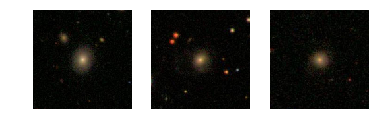

In [17]:
# elliptical class
for num, file in enumerate(os.listdir(os.path.join(my_data, 'train', 'elliptical'))[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'elliptical', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

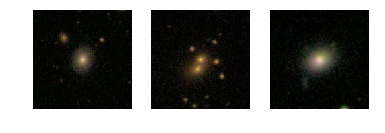

In [18]:
# lenticular class
for num, file in enumerate(os.listdir(os.path.join(my_data, 'train', 'lenticular'))[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'lenticular', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

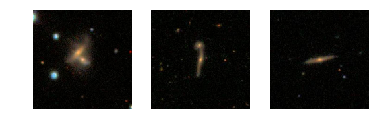

In [19]:
# spiral class
for num, file in enumerate(os.listdir(os.path.join(my_data, 'train', 'spiral'))[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'spiral', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

## 3. Build and Train The Model

Set the directories that contain the training and validation images.

In [20]:
train_dir = os.path.join(my_data, 'train')
validation_dir = os.path.join(my_data, 'validation')

Set the batch size:

In [21]:
BS = 32

And create an image generator for training and validation. We also normalize every pixel using the rescale option.

In [22]:
train_datagen = ImageDataGenerator(rescale = 1.0/255)
validation_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [23]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=BS,
                                                    class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size=(150,150),
                                                         batch_size=BS,
                                                         class_mode='categorical')

Found 8044 images belonging to 3 classes.
Found 3450 images belonging to 3 classes.


Define our model:

In [24]:
model = tf.keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron fully connected hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

We can inspect a summary of our model:

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Compile the model, using an `adam` optimizer, and `categorical_crossentropy` loss:

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Fit the model using the training data generator, and the validation generator for performing validation, for `20` epochs, and save the model:

In [28]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=8044/BS,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=3450/BS,
                              verbose=1)
model.save('my_model.h5')

Epoch 1/10
252/251 [==============================] - 584s 2s/step - loss: 0.7319 - acc: 0.6040 - val_loss: 0.5361 - val_acc: 0.7310
Epoch 2/10
252/251 [==============================] - 579s 2s/step - loss: 0.5377 - acc: 0.7278 - val_loss: 0.5241 - val_acc: 0.7290
Epoch 3/10
252/251 [==============================] - 578s 2s/step - loss: 0.4774 - acc: 0.7708 - val_loss: 0.4582 - val_acc: 0.7843
Epoch 4/10
252/251 [==============================] - 578s 2s/step - loss: 0.4145 - acc: 0.8097 - val_loss: 0.4030 - val_acc: 0.8191
Epoch 5/10
252/251 [==============================] - 578s 2s/step - loss: 0.3737 - acc: 0.8317 - val_loss: 0.3385 - val_acc: 0.8539
Epoch 6/10
252/251 [==============================] - 577s 2s/step - loss: 0.3364 - acc: 0.8556 - val_loss: 0.2966 - val_acc: 0.8751
Epoch 7/10
252/251 [==============================] - 578s 2s/step - loss: 0.3085 - acc: 0.8662 - val_loss: 0.3087 - val_acc: 0.8597
Epoch 8/10
252/251 [==============================] - 584s 2s/step - 

Plot the training and validation accuracy history acrros the different epochs:

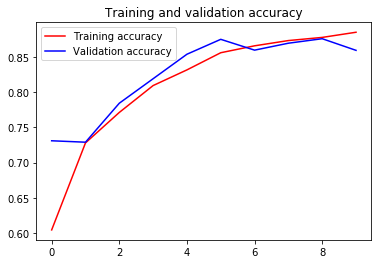

In [29]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

## 4. Results

Load the model:

In [30]:
model = tf.keras.models.load_model('my_model.h5')

And just illustrate the prediction method on some examples:

elliptical-1.jpg [[1. 0. 0.]]
elliptical-2.jpg [[1. 0. 0.]]
elliptical-3.jpg [[1. 0. 0.]]
spiral-1.jpg [[0. 0. 1.]]
spiral-2.jpg [[0. 0. 1.]]
spiral-3.jpg [[0. 0. 1.]]


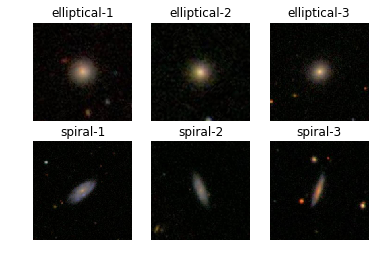

In [31]:
rows = 2
for num, file in enumerate(os.listdir('testing')):
    img = image.load_img(os.path.join('testing', file) , target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images)
    plt.subplot(rows, 3, num+1)
    plt.title(file.split('.')[0])
    plt.axis('off')
    plt.imshow(img)
    print(file, classes)